ADF Statistic: -7.17
p-value: 0.00000


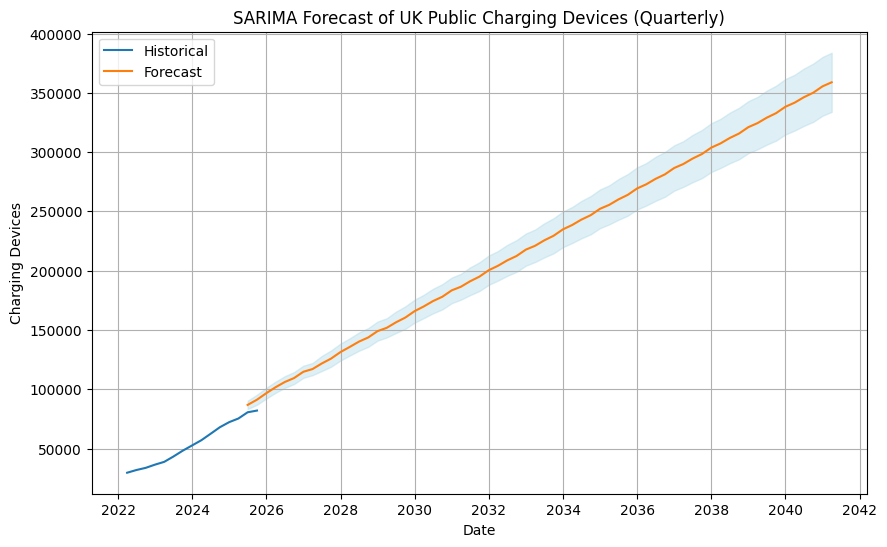


Forecasted Charging Device Counts:
                 Forecast
Date                     
2030-12-31  183364.712424
2035-12-31  269305.812974
2040-12-31  355445.735638


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("Quarterly_Charging_Devices.csv", parse_dates=["Date"])
df = df.sort_values("Date")

df.set_index("Date", inplace=True)

series = df["Total Charging Devices"]
series = series.replace([np.inf, -np.inf], np.nan).dropna()

if len(series.unique()) > 1:
    adf_result = adfuller(series)
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.5f}")
else:
    print("Cannot run ADF test: Series is constant.")


model = SARIMAX(series,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 4),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
future_steps = (2041 - series.index[-1].year) * 4
forecast = results.get_forecast(steps=future_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

last_date = series.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=future_steps, freq='QE')
series.index = pd.date_range(start=series.index[0], periods=len(series), freq='QE')

plt.figure(figsize=(10, 6))
plt.plot(series, label='Historical')
plt.plot(future_dates, forecast_mean, label='Forecast')
plt.fill_between(future_dates, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], color='lightblue', alpha=0.4)
plt.title("SARIMA Forecast of UK Public Charging Devices (Quarterly)")
plt.xlabel("Date")
plt.ylabel("Charging Devices")
plt.legend()
plt.grid(True)
plt.show()

forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecast": forecast_mean
})
forecast_df.set_index("Date", inplace=True)

summary_values = forecast_df.loc[forecast_df.index.year.isin([2030, 2035, 2040]) & (forecast_df.index.month == 12)]
print("\nForecasted Charging Device Counts:")
print(summary_values)
